In [2]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/21349
# 标题：宏观指标择时检测

from jqdata import *
import numpy as np
import pandas as pd
import datetime as dt
from six import StringIO
from dateutil.parser import parse
import pickle
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import scipy
import talib as tl
import warnings

from sklearn.metrics import roc_curve
warnings.filterwarnings('ignore')
mpl.rcParams['font.family']='serif'
mpl.rcParams['axes.unicode_minus']=False # 处理负号


def get_profit(data,start_date,end_date,rate_riskfree=0):
    df_pct=pd.DataFrame()
    prices = get_price('000300.XSHG',start_date=start_date,end_date=end_date,fields='close')['close']
    df_pct['pct']=prices.pct_change()
    rate_riskfree = 0
    df_pct = pd.concat([df_pct,data],axis=1)[start_date:end_date].dropna()
    df_pct['net_value'] =(df_pct['pct']+1).cumprod()
    df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
    df_pct[['net_value','net_value_timing']].plot(figsize=(15,6))
    return df_pct


#此函数调试用，部分情况下dataframe中有部分元素非实数
def get_float(data):
    '''
    将dataframe中的str类型转换成float
    data:dataframe
    '''
    values = data.values
    index = data.index
    columns = data.columns
    l = []
    for ind in range(len(index)):
        ind_list = []
        for col in range(len(columns)):
            f = float(values[ind][col])
            ind_list.append(f)
        l.append(ind_list)
    df = pd.DataFrame(l, index=index, columns=columns)
    return df


def get_month_list(start_date, end_date):
    sy = int(start_date[:4])
    ey = int(end_date[:4])
    sm = int(start_date[5:7])
    em = int(end_date[5:7])
    l = []
    for y in range(sy, ey + 1):
        if y == sy:
            for i in range(sm, 13):
                if i < 10:
                    s = str(y) + '-' + '0' + str(i)
                    l.append(s)
                else:
                    s = str(y) + '-' + str(i)
                    l.append(s)

        elif y == ey:
            for i in range(1, em + 1):
                if i < 10:
                    s = str(y) + '-' + '0' + str(i)
                    l.append(s)
                else:
                    s = str(y) + '-' + str(i)
                    l.append(s)
        else:
            for i in range(1, 13):
                if i < 10:
                    s = str(y) + '-' + '0' + str(i)
                    l.append(s)
                else:
                    s = str(y) + '-' + str(i)
                    l.append(s)
    return l

In [3]:
def bbands_select_time(data,bulin_n=25,nbdevup_=1.8,nbdevdn_=1.8,model='up'):
    col = data.columns[0]
    upperband,middleband,lowerband = (tl.BBANDS(data[col].values, timeperiod=bulin_n, nbdevup=nbdevup_, nbdevdn=nbdevdn_))
    data['BBAND_upper']=upperband
    data['BBAND_middle']=middleband
    data['BBAND_lower']=lowerband
    pre_position = 0
    if model == 'up':
        for date in data.index:
            if data.loc[date,col]<data.loc[date,'BBAND_middle']:
                data.loc[date,'position']=0
            elif data.loc[date,col]>data.loc[date,'BBAND_upper']:
                data.loc[date,'position']=1.0
            else:
                data.loc[date,'position']=pre_position
            pre_position=data.loc[date,'position']
        data['position']=data['position'].shift(1)
    elif model == 'lower':
        for date in data.index:
            if data.loc[date,col]>data.loc[date,'BBAND_middle']:
                data.loc[date,'position']=0
            elif data.loc[date,col]<data.loc[date,'BBAND_lower']:
                data.loc[date,'position']=1.0
            else:
                data.loc[date,'position']=pre_position
            pre_position=data.loc[date,'position']
        data['position']=data['position'].shift(1)
    return data



def get_rolling_positon(data,n=3,delay=2,how='up'):
    '''
    data:dataframe or series,输入数据,必须是一列
    n:移动平均窗口大小
    delay:取决于宏观数据发布时间，一般宏观数据都是本月中旬发布上月数据，每月初能拿到的最近数据为2月前
    '''
    if how == 'up':
        position = (data.rolling(n).mean() > data.rolling(n).mean().shift(1))*1.0
    else:
        position = (data.rolling(n).mean() < data.rolling(n).mean().shift(1))*1.0
    if isinstance(position,pd.Series):
        position = position.to_frame()
    position.columns = ['position']
    position = position.shift(delay).dropna()
    return position


def get_position_from_continus_increase(data,n=2,delay=2,how='up'):
    '''
    data:dataframe or series,输入数据,必须是一列
    n:连续n次上涨或下跌
    how:默认up，连续上涨n天position标记为1
    delay:取决于宏观数据发布时间，一般宏观数据都是本月中旬发布上月数据，每月初能拿到的最近数据为2月前
    '''
    index = list(data.index)
    length = len(index)
    l = []
    for i in range(n,length):
        if how == 'up':
            counter = 0
            for j in range(i-n,i):
                if data.loc[index[j]]< data.loc[index[j+1]]:
                    counter += 1
            if counter == n:
                position = 1
                l.append(position)
            else:
                position = 0
                l.append(position)
                    
        else:
            counter = 0
            for j in range(i-n,i):
                if data.loc[index[j]] > data.loc[index[j+1]]:
                    counter += 1
            if counter == n:
                position = 1
                l.append(position)
            else:
                position = 0
                l.append(position)
    res = pd.DataFrame(l,columns=['position'],index=index[n:])
    res = res.shift(delay).dropna()
    return res

def get_position_from_long_short_monving_average(data,long_n=12,short_n=3,delay=2,how='up'):
    '''
    data:dataframe or series,输入数据,必须是一列
    long_n:移动平均长期线计算窗口
    short_n:移动平均短期线窗口
    n:连续n次上涨或下跌
    how:默认up，连续上涨n天position标记为1
    delay:取决于宏观数据发布时间，一般宏观数据都是本月中旬发布上月数据，每月初能拿到的最近数据为2月前
    '''    
    long_ma = data.rolling(long_n).mean()
    short_ma = data.rolling(short_n).mean()
    diff = short_ma -  long_ma
    diff[diff>0] = 1
    diff[diff<=0] = 0
    if isinstance(diff,pd.Series):
        diff = diff.to_frame()
        diff.columns = ['position']
    res = diff.shift(delay).dropna()
    return res

def get_combine_positon(t,delay=3,continus_n=2,rolling_n=3,long_n=12,short_n=3,how='up'):
    p_continus_increase = get_position_from_continus_increase(t,n=continus_n,delay=delay,how=how)
    p_rolling = get_rolling_positon(t,n=rolling_n,delay=delay,how=how)
    p_lsma = get_position_from_long_short_monving_average(t,long_n=long_n,short_n=short_n,delay=delay,how=how)
    p = pd.concat([p_lsma,p_rolling,p_continus_increase],axis=1).dropna()
    index = p.index
    p_lsma = p_lsma.loc[index]
    p_rolling = p_rolling.loc[index]
    p_continus_increase = p_continus_increase.loc[index]

    p_all = (p_lsma + p_rolling + p_continus_increase) / 3.0
    p_all[p_all > 0.5] = 1
    p_all[p_all<0.5] = 0
    return p_all

In [4]:

def get_profit_monthly(data,start_date,end_date,rate_riskfree=0):
    '''
    data:position数据，1列，前期计算出择时position
    start_date:datetime or str, 开始时间，此时间要和data时间有交集，通常是对应
    end_date:结束时间
    rate_riskfree:无风险利率
    '''
    df_pct=pd.DataFrame()
    prices = get_price('000300.XSHG',start_date=start_date,end_date=end_date,fields='close')['close']
    prices_M = prices.resample('M',how='last')
    month_list = get_month_list(start_date,end_date)
    prices_M.index = month_list
    df_pct['pct']=prices_M.pct_change()
    rate_riskfree = 0
    df_pct = pd.concat([df_pct,data],axis=1).loc[month_list].dropna()

    df_pct['net_value'] =(df_pct['pct']+1).cumprod()
    df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
    f = plt.figure(figsize=(15,6))
    ax = f.add_subplot(1,1,1)
    ax.plot(df_pct[['net_value','net_value_timing']])
    ax.set_xticks(month_list[::12])
    return df_pct


#获取label值
def get_profit_monthly_(start_date,end_date,cut_list=[-0.00,0.00],label=True,rate_riskfree=0):
    '''
    data:position数据，1列，前期计算出择时position
    start_date:datetime or str, 开始时间，此时间要和data时间有交集，通常是对应
    end_date:结束时间
    rate_riskfree:无风险利率
    cut_list:分类切点，注意二分类和多分类时后续算法的区别
    label:决定输出的是分类结果还是连续结果
    '''
    df_pct=pd.DataFrame()
    prices = get_price('000300.XSHG',start_date=start_date,end_date=end_date,fields='close')['close']
    prices_M = prices.resample('M',how='last')
    month_list = get_month_list(start_date,end_date)
    prices_M.index = month_list
    df_pct['pct']=prices_M.pct_change().dropna()
    def fun(x):
        if x > cut_list[-1]:
            y = 1
        elif x < cut_list[0]:
            y = -1
        else:
            y = 0
        return y
    if label:
        df_pct = df_pct.applymap(lambda x: fun(x))
    return df_pct

#计算最大回撤函数
#输入收益数据
#返回最大回撤
def find_max_drawdown(returns):
    # 定义最大回撤的变量
    result = 0
    # 记录最高的回报率点
    historical_return = 0
    # 遍历所有日期
    for i in range(len(returns)):
        # 最高回报率记录
        historical_return = max(historical_return, returns[i])
        # 最大回撤记录
        drawdown = 1 - (returns[i]) / (historical_return)
        # 记录最大回撤
        result = max(drawdown, result)
    # 返回最大回撤值
    return result


#输入交易指令 1为交易 0为清盘
#返回交易状况  基准收益 策略收益   胜率  最大回撤
def get_profit_res(data,start_date,end_date,rate_riskfree=0,plot=True):
    
    '''
    data:position数据，1列，前期计算出择时position
    start_date:datetime or str, 开始时间，此时间要和data时间有交集，通常是对应
    end_date:结束时间
    rate_riskfree:无风险利率
    '''
    df_pct=pd.DataFrame()
    prices = get_price('000300.XSHG',start_date=start_date,end_date=end_date,fields='close')['close']

    prices_M = prices.resample('M',how='last')

    month_list = get_month_list(start_date,end_date)
    
    prices_M.index = month_list
    
    df_pct['pct']=prices_M.pct_change()
  
  
    
    df_pct['pct_position'] = df_pct['pct']
    df_pct['pct_position'][df_pct['pct_position']>0] = 1
    df_pct['pct_position'][df_pct['pct_position']<0] = 0
    
    rate_riskfree = 0
    
    df_pct = pd.concat([df_pct,data],axis=1).loc[month_list].dropna()
    #计算胜率
    win_rate = df_pct['position'] * df_pct['pct_position']
    win_rate = win_rate.sum()/df_pct['position'].sum()
    
    df_pct['net_value'] =(df_pct['pct']+1).cumprod()
    df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
    
    if plot == True:
        f = plt.figure(figsize=(15,6))
        ax = f.add_subplot(1,1,1)
        ax.plot(df_pct[['net_value','net_value_timing']])
        ax.set_xticks(month_list[::12])
    profit_res = df_pct.ix[-1,['net_value','net_value_timing']].to_frame().stack().unstack(0)
    profit_res['win_rate'] = win_rate
    profit_res['profit_ratio'] = profit_res['net_value_timing'] / profit_res['net_value']
    profit_res["max_drawdown"]=find_max_drawdown(df_pct['net_value_timing'])
    
    #可以max_drawdow加上一个数字，数字越大回撤的程度约不重要更加注重收益
    profit_res["res_score"]=profit_res['profit_ratio']/(profit_res["max_drawdown"]+0)
    return profit_res

In [5]:
def get_factor_profit_compare(t,delay,rolling_n=3,continus_inc=2,how='up',plot=False):
    p_lsma = get_position_from_long_short_monving_average(t,delay=delay,how=how)
    p_rolling = get_rolling_positon(t,3,delay=delay,how=how)
    p_continus_increase = get_position_from_continus_increase(t,2,delay=delay,how=how)
    
    p = pd.concat([p_lsma,p_rolling,p_continus_increase],axis=1).dropna()
    index = p.index
    p_lsma = p_lsma.loc[index]
    p_rolling = p_rolling.loc[index]
    p_continus_increase = p_continus_increase.loc[index]

    p_all = (p_lsma + p_rolling + p_continus_increase) / 3.0
    p_all[p_all > 0.5] = 1
    p_all[p_all<0.5] = 0

    profit_lsma = get_profit_res(p_lsma,start_date,end_date,plot=plot)
    profit_lsma.index = ['lsma']

    profit_rolling = get_profit_res(p_rolling,start_date,end_date,plot=plot)
    profit_rolling.index = ['rolling']

    profit_continus_increase = get_profit_res(p_continus_increase,start_date,end_date,plot=plot)
    profit_continus_increase.index = ['continus_increase']
    
    profit_all = get_profit_res(p_all,start_date,end_date,plot=plot)
    profit_all.index = ['combine']

    profit = pd.concat([profit_lsma,profit_rolling,profit_continus_increase,profit_all])
    profit['profit_ratio'] = profit['net_value_timing'] / profit['net_value']
    return profit


def check_all_factors(t):
    col = t.columns
    for c in col:
        print('****************************')
        print(c)
        data_input = t[c].sort_index()
        profit = get_factor_profit_compare(data_input,delay=2,how='up')



In [6]:


#通过遍历所有参数确定交易指标
def get_all_position(data,delay_list=[0,3],continus_n=2,rolling_n=[1,3],long_n=[12,14],short_n=[3,4],how=["up","dowm"]):
    dict={}
    for how_index in how:
        for delay_index in range(delay_list[0],delay_list[1]+1):
            dict["continus_increase_delay"+str(delay_index)+"_"+how_index]= get_position_from_continus_increase(data,n=continus_n,delay=delay_index,how=how_index)
            
            for rolling_index in range(rolling_n[0],rolling_n[1]+1):
                dict['rolling'+str(rolling_index)+"_delay"+str(delay_index)+"_"+how_index]=get_rolling_positon(data,n=rolling_index,delay=delay_index,how=how_index)
                for long_index in range(long_n[0],long_n[1]+1):
                    for short_index in short_n:
                        dict['lsma_long'+str(long_index)+"_short"+str(short_index)+"_delay"+str(delay_index)+"_"+how_index]=get_position_from_long_short_monving_average(data,long_n=long_index,short_n=short_index,delay=delay_index,how=how_index) 
                        dict['combine_rolling'+str(rolling_index)+"_long"+str(long_index)+"_short"+str(short_index)+"_delay"+str(delay_index)+"_"+how_index]= get_combine_positon(data,continus_n=continus_n,rolling_n=rolling_index,long_n=long_index,short_n=short_index,delay=delay_index,how=how_index) 
    return dict



#统计每个交易指标的最终收益率和最大回撤等数值
#并且返回自己最理想的交易策略
def get_all_res(data_dict):
    res_df=pd.DataFrame(columns=["net_value","net_value_timing" , "win_rate","profit_ratio","max_drawdown","res_score"])
    for key in data_dict.keys():
        res_df.loc[key]=get_profit_res(data_dict[key],start_date,end_date,plot=False).values[0]
    #可以选择最大收益，也可选择调和超额收益和最大回撤
    res_df=res_df.sort_values(by=["res_score"],ascending=False)
    

    print(res_df.index[0])
    return res_df

In [7]:
def get_all_continus_position(data,delay_list=[0,6],continus_n=[2,5],how=["up","dowm"]):
    dict={}
    for how_index in how:
        for delay_index in range(delay_list[0],delay_list[-1]+1):
            for continus_index in range(continus_n[0],continus_n[-1]+1):
                dict["continus_increase_delay"+str(delay_index)+"_continus"+str(continus_index)+"_"+how_index]= get_position_from_continus_increase(data,n=continus_index,delay=delay_index,how=how_index)
    return dict

def get_all_rolling_position(data,delay_list=[0,6],rolling_n=[0,5],how=["up","dowm"]):
    dict={}
    for how_index in how:
        for delay_index in range(delay_list[0],delay_list[-1]+1):
            for rolling_index in range(rolling_n[0],rolling_n[-1]+1):
                dict["rolling_delay"+str(delay_index)+"_rolling"+str(rolling_index)+"_"+how_index]= get_rolling_positon(data,n=rolling_index,delay=delay_index,how=how_index)
    return dict

def get_all_lsma_position(data,delay_list=[0,6],long_n=[10,15],short_n=[3,5],how=["up","dowm"]):
    dict={}
    for how_index in how:
        for delay_index in range(delay_list[0],delay_list[-1]+1):
            for long_index in range(long_n[0],long_n[-1]+1):
                for short_index in range(short_n[0],short_n[-1]+1):
                    dict["lsma_delay"+str(delay_index)+"_long"+str(long_index)+"_shrot"+str(short_index)+"_"+how_index]= get_position_from_long_short_monving_average(data,long_n=long_index,short_n=short_index,delay=delay_index,how=how_index)
    return dict

In [8]:
def obj_hot(obj):
    dict_0=get_all_continus_position(obj)
    res_0=get_all_res(dict_0)
    dict_1=get_all_rolling_position(obj)
    res_1=get_all_res(dict_1)
    dict_2=get_all_lsma_position(obj)
    res_2=get_all_res(dict_2)
    plt.figure(figsize=(16,20), dpi= 70)
    sns.heatmap(res_0,annot=True, vmax=3,vmin = 0 ,cmap="YlGnBu")
    plt.figure(figsize=(16,20), dpi= 70)
    sns.heatmap(res_1,annot=True, vmax=3,vmin = 0 ,cmap="YlGnBu")
    plt.figure(figsize=(16,50), dpi= 70)
    sns.heatmap(res_2,annot=True, vmax=3,vmin = 0 ,cmap="YlGnBu")


In [9]:
start_date = '2007-01-01'
end_date = '2019-06-29'
month_list = get_month_list(start_date,end_date)

,net_value,net_value_timing,win_rate,profit_ratio,max_drawdown,res_score
2019-06,0.818387,2.639835,0.685185,3.225657,0.190076,16.97033


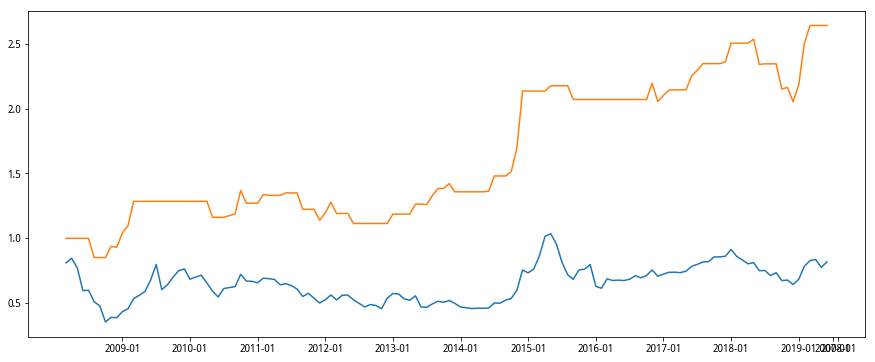

In [10]:

def get_MAC_MONEY_SUPPLY_MONTH(month_list):
    mei = macro.MAC_MONEY_SUPPLY_MONTH
    q = query(mei).filter(mei.stat_month.in_(month_list))
    mac_economic = macro.run_query(q)
    mac_economic = mac_economic.set_index('stat_month').sort_index()

    return mac_economic.shift(1)

mac_manufacturing =get_MAC_MONEY_SUPPLY_MONTH(month_list)

#m1增长率-m2增长率
m1_m2yoy=mac_manufacturing["m1_yoy"]-mac_manufacturing["m2_yoy"]

#------------------超额收益/最大回撤----------------------
#combine_rolling2_long13_short4_delay1_dowm 17
m1_m2yoy_position=get_combine_positon(m1_m2yoy,delay=1,continus_n=2,rolling_n=2,long_n=13,short_n=4,how='dowm')

#------------------超额收益----------------------
#combine_rolling2_long13_short4_delay1_dowm

# m1_m2yoy_position=get_combine_positon(m1_m2yoy,delay=1,continus_n=2,rolling_n=2,long_n=13,short_n=4,how='dowm')




#通过图形选择最好的指标
# dict_=get_all_position(m1_m2yoy,delay_list=[0,3],continus_n=2,rolling_n=[1,3],long_n=[12,14],short_n=[3,4],how=["up","dowm"])
# res_=get_all_res(dict_)
# plt.figure(figsize=(16,50), dpi= 70)
# sns.heatmap(res_,annot=True, vmax=3,vmin = 0 ,cmap="YlGnBu")
get_profit_res(m1_m2yoy_position,start_date,end_date)

In [11]:
import tushare as ts
cpi_df=ts.get_cpi()
ppi_df=ts.get_ppi()

def change_time_split(str,before=".",after="-"):
    str_list=str.split(before)
    if int(str_list[1])<10:
        str_list[1]="0"+str_list[1]
    return after.join(str_list)

for i in range(len(cpi_df["month"])):
    cpi_df["month"][i]=change_time_split(cpi_df["month"][i])
    
for i in range(len(ppi_df["month"])):
    ppi_df["month"][i]=change_time_split(ppi_df["month"][i])

cpi_df=cpi_df.set_index("month").sort_index()
ppi_df=ppi_df.set_index("month").sort_index()

In [12]:

cpi_df=cpi_df.pct_change().shift(1)
ppi_df=ppi_df.pct_change().shift(1)

,net_value,net_value_timing,win_rate,profit_ratio,max_drawdown,res_score
2019-06,1.375231,2.827134,0.655172,2.055752,0.146337,14.048103


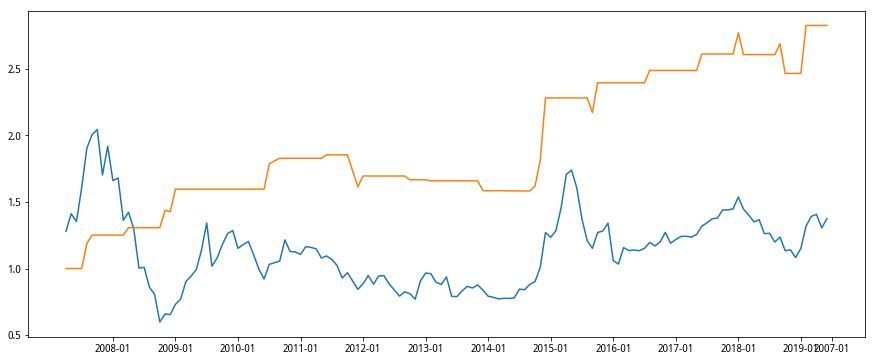

In [13]:

ppi_cpi_df=pd.concat([cpi_df,ppi_df],axis=1)
#ppi的增长-cpi的增长
ppi_cpi_df["position"]=ppi_cpi_df["ppi"]-ppi_cpi_df["cpi"]
ppi_cpi=ppi_cpi_df.loc[month_list,"position"]

#------------------超额收益/最大回撤----------------------
# continus_increase_delay1_dowm 14
ppi_cpi_position= get_position_from_continus_increase(ppi_cpi,n=2,delay=1,how='dowm')

#------------------超额收益----------------------
# continus_increase_delay1_dowm 14
# ppi_cpi_position= get_position_from_continus_increase(ppi_cpi,n=2,delay=1,how='dowm')


# dict_=get_all_position(ppi_cpi,delay_list=[0,3],continus_n=2,rolling_n=[1,3],long_n=[12,14],short_n=[3,4],how=["up","dowm"])
# res_=get_all_res(dict_)
# plt.figure(figsize=(16,50), dpi= 70)
# sns.heatmap(res_,annot=True, vmax=3,vmin = 0 ,cmap="YlGnBu")
get_profit_res(ppi_cpi_position,start_date,end_date)

stat_month
2007-01     NaN
2007-02    55.1
2007-03    53.1
2007-04    56.1
2007-05    58.6
2007-06    55.7
2007-07    54.5
2007-08    53.3
2007-09    54.0
2007-10    56.1
2007-11    53.2
2007-12    55.4
2008-01    55.3
2008-02    53.0
2008-03    53.4
2008-04    58.4
2008-05    59.2
2008-06    53.3
2008-07    52.0
2008-08    48.4
2008-09    48.4
2008-10    51.2
2008-11    44.6
2008-12    38.8
2009-01    41.2
2009-02    45.3
2009-03    49.0
2009-04    52.4
2009-05    53.5
2009-06    53.1
           ... 
2017-01    51.4
2017-02    51.3
2017-03    51.6
2017-04    51.8
2017-05    51.2
2017-06    51.2
2017-07    51.7
2017-08    51.4
2017-09    51.7
2017-10    52.4
2017-11    51.6
2017-12    51.8
2018-01    51.6
2018-02    51.3
2018-03    50.3
2018-04    51.5
2018-05    51.4
2018-06    51.9
2018-07    51.5
2018-08    51.2
2018-09    51.3
2018-10    50.8
2018-11    50.2
2018-12    50.0
2019-01    49.4
2019-02    49.5
2019-03    49.2
2019-04    50.5
2019-05    50.1
2019-06    49.4
Name: pmi, Le

,net_value,net_value_timing,win_rate,profit_ratio,max_drawdown,res_score
2019-06,0.716635,3.273181,0.666667,4.567432,0.24135,18.924487


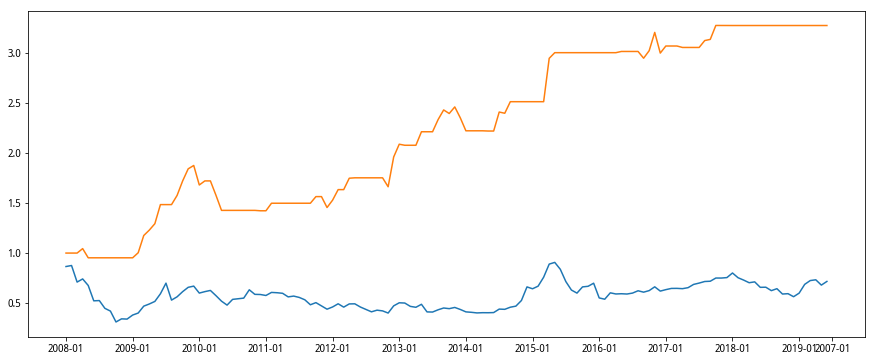

In [24]:
def get_MAC_MANUFACTURING_PMI(month_list):
    
    mei = macro.MAC_MANUFACTURING_PMI
    q = query(mei).filter(mei.stat_month.in_(month_list))
    mac_economic = macro.run_query(q)
    mac_economic = mac_economic.set_index('stat_month').sort_index()

    return mac_economic.shift(1)


mac_manufacturing =get_MAC_MANUFACTURING_PMI(month_list)



# 制造业采购经理指数 
pmi = mac_manufacturing['pmi']
print(pmi)
#生产指数 
produce_idx = mac_manufacturing['produce_idx']
#进口指数 
import_idx = mac_manufacturing['import_idx']
#供应商配送时间指数
delivery_time_idx = mac_manufacturing['delivery_time_idx']
#产成品库存指数
finished_produce_idx = mac_manufacturing['finished_produce_idx']
#采购量指数	
purchase_quantity_idx = mac_manufacturing['purchase_quantity_idx']


#------------------超额收益（追求最大收益不顾回撤）----------------------
# #combine_rolling2_long12_short4_delay0_up
# pmi_position=get_combine_positon(pmi,delay=0,continus_n=2,rolling_n=2,long_n=12,short_n=4,how="up")

# # combine_rolling1_long12_short3_delay2_up
# produce_idx_position=get_combine_positon(produce_idx,delay=2,continus_n=2,rolling_n=1,long_n=12,short_n=3,how="up")

# #combine_rolling2_long14_short4_delay0_up
# import_idx_position = get_combine_positon(import_idx,delay=0,continus_n=2,rolling_n=2,long_n=14,short_n=4,how="up")

# # combine_rolling3_long12_short3_delay0_dowm
# delivery_time_idx_position = get_combine_positon(delivery_time_idx,delay=0,continus_n=2,rolling_n=3,long_n=12,short_n=3,how="dowm")

# #combine_rolling1_long12_short3_delay1_dowm
# finished_produce_idx_position=get_combine_positon(finished_produce_idx,delay=1,continus_n=2,rolling_n=1,long_n=12,short_n=3,how="dowm")

# # combine_rolling2_long12_short3_delay0_up
# purchase_quantity_idx_position=get_combine_positon(purchase_quantity_idx,delay=0,continus_n=2,rolling_n=2,long_n=13,short_n=3,how="up")



#------------------超额收益/最大回撤----------------------

#combine_rolling2_long12_short4_delay0_up  14
pmi_position=get_combine_positon(pmi,delay=0,continus_n=2,rolling_n=2,long_n=12,short_n=4,how="up")

#combine_rolling1_long12_short3_delay2_up  9.7
produce_idx_position=get_combine_positon(produce_idx,delay=2,continus_n=2,rolling_n=1,long_n=12,short_n=3,how="up")

#combine_rolling2_long14_short4_delay0_up  17
import_idx_position = get_combine_positon(import_idx,delay=0,continus_n=2,rolling_n=2,long_n=14,short_n=4,how="up")

#lsma_long12_short4_delay3_dowm  8
delivery_time_idx_position = get_position_from_long_short_monving_average(delivery_time_idx,long_n=12,short_n=4,delay=3,how='dowm')

#combine_rolling2_long13_short4_delay1_up 7.7
finished_produce_idx_position =get_combine_positon(finished_produce_idx,delay=1,continus_n=2,rolling_n=2,long_n=13,short_n=4,how="up")

#combine_rolling2_long12_short3_delay0_up  12
purchase_quantity_idx_position = get_combine_positon(purchase_quantity_idx,delay=0,continus_n=2,rolling_n=2,long_n=12,short_n=3,how="up")





all_position = pd.concat([pmi_position,produce_idx_position,import_idx_position,delivery_time_idx_position,finished_produce_idx_position,purchase_quantity_idx_position],axis=1)
col = ["pmi_positon","produce_idx_positon","import_idx_positon","delivery_time_idx_positon","finished_produce_idx_positon","purchase_quantity_idx_positon"]
all_position.columns = col

all_position = all_position.fillna(0)
index = all_position.index
weights = [1,1,1,1,1,1]
combine_position = (all_position * weights).sum(axis=1)
df_position = pd.DataFrame(combine_position,index=index,columns=['position'])
df_position = df_position / sum(weights)

def fun_(x):
    if x > 0.45:
        y = 1
    elif x < 0.4:
        y = 0
    else:
        y = 0.5
    return y
df_position = df_position.applymap(fun_)






get_profit_res(df_position,start_date,end_date)
# dict_=get_all_position(pmi,delay_list=[0,3],continus_n=2,rolling_n=[1,3],long_n=[12,14],short_n=[3,4],how=["up","dowm"])
# res_=get_all_res(dict_)
# plt.figure(figsize=(16,50), dpi= 70)
# sns.heatmap(res_,annot=True, vmax=3,vmin = 0 ,cmap="YlGnBu")



,net_value,net_value_timing,win_rate,profit_ratio,max_drawdown,res_score
2019-06,1.880962,2.82944,0.625,1.504251,0.224572,6.698289


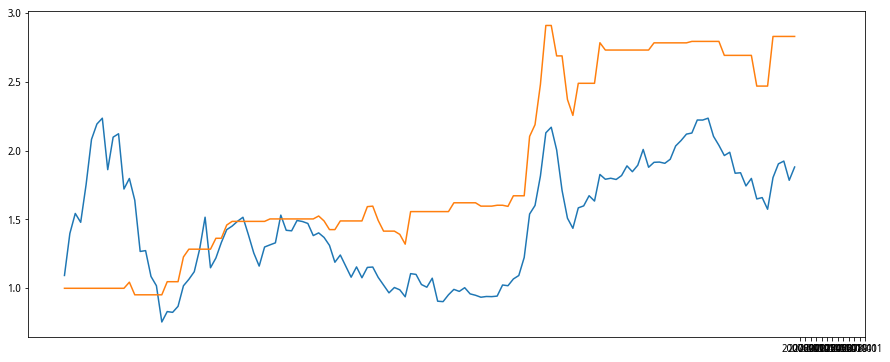

In [15]:
'''
macro.MAC_FIXED_INVESTMENT,数据本身延迟2个月

delay=2，how=down
1.expand_yoy (10,4)
2.secondary_yoy rolling=2

delay=3 how=up
1.primary_yoy rolling=2 低频高效

delay=3 how=down
1.expand_yoy (8,4) continue = 2 低频高效
2.expand_yoy 连续上涨2个单位
'''

def get_MAC_FIXED_INVESTMENT(month_list):
    mei = macro.MAC_FIXED_INVESTMENT
    q = query(mei).filter(mei.stat_month.in_(month_list))
    mac_economic = macro.run_query(q)
    mac_economic = mac_economic.set_index('stat_month').sort_index()
    return mac_economic.shift(1)

mac_fixed = get_MAC_FIXED_INVESTMENT(month_list)


#扩建固定资产投资完成额_累计增长数 rolling1 d0 up
expand_yoy = mac_fixed['expand_yoy']
#第二产业固定资产投资完成额_累计增长数 
secondary_yoy = mac_fixed['secondary_yoy']
#第一产业固定资产投资完成额_累计增长
primary_yoy = mac_fixed['primary_yoy']

# #------------------超额收益----------------------
# #combine_rolling1_long12_short3_delay2_dowm
# expand_yoy_position=  get_combine_positon(expand_yoy,delay=2,continus_n=2,rolling_n=1,long_n=12,short_n=3,how='dowm')

# #combine_rolling1_long13_short4_delay0_dowm
# secondary_yoy_position  = get_combine_positon(secondary_yoy,delay=0,continus_n=2,rolling_n=1,long_n=13,short_n=4,how='dowm')

# # rolling2_delay1_up
# primary_yoy_position=  get_rolling_positon(primary_yoy,n=2,delay=1,how='up')


#------------------超额收益/最大回撤----------------------

# combine_rolling1_long12_short3_delay2_dowm   8.6
expand_yoy_position = get_combine_positon(expand_yoy,delay=2,continus_n=2,rolling_n=1,long_n=12,short_n=3,how='dowm')

# combine_rolling1_long13_short3_delay0_dowm  5.7
secondary_yoy_position  = get_combine_positon(secondary_yoy,delay=0,continus_n=2,rolling_n=1,long_n=13,short_n=3,how='dowm')

# rolling2_delay1_up   10
primary_yoy_position = get_rolling_positon(primary_yoy,n=2,delay=1,how='up')



all_position = pd.concat([expand_yoy_position,secondary_yoy_position,primary_yoy_position],axis=1)
col = ["expand_yoy_position","secondary_yoy_position","primary_yoy_position" ]
all_position.columns = col

all_position = all_position.fillna(0)
index = all_position.index
            
weights = [1,1,1]
combine_position = (all_position[col] * weights).sum(axis=1)
df_position = pd.DataFrame(combine_position,index=index,columns=['position'])
df_position = df_position / sum(weights)

def fun_(x):
    if x > 0.45:
        y = 1
    elif x < 0.4:
        y = 0
    else:
        y = 0.5
    return y
df_position = df_position.applymap(fun_)




get_profit_res(df_position ,start_date,end_date)
# dict_=get_all_position(primary_yoy,delay_list=[0,3],continus_n=2,rolling_n=[1,3],long_n=[12,14],short_n=[3,4],how=["up","dowm"])
# res_=get_all_res(dict_)
# plt.figure(figsize=(16,50), dpi= 70)
# sns.heatmap(res_,annot=True, vmax=3,vmin = 0 ,cmap="YlGnBu")



stat_month
2007-02     NaN
2007-03    18.9
2007-04    25.9
2007-05    25.5
2007-06    26.5
2007-07    27.9
2007-08    26.3
2007-09    25.3
2007-10    25.8
2007-11    24.0
2007-12    24.3
2008-02    23.3
2008-03    22.4
2008-04    24.1
2008-05    23.2
2008-06    22.1
2008-07    22.5
2008-08    20.7
2008-09    19.1
2008-10    19.2
2008-11    15.9
2008-12    14.1
2009-02    16.3
2009-03    25.1
2009-04    18.7
2009-05    16.9
2009-06    18.8
2009-07    19.7
2009-08    19.9
2009-09    19.6
           ... 
2016-10     6.4
2016-11     6.8
2016-12     6.4
2017-02     5.2
2017-03     NaN
2017-04     7.4
2017-05     6.8
2017-06     6.6
2017-07     7.4
2017-08     5.5
2017-09     3.7
2017-10     5.2
2017-11     5.0
2017-12     5.0
2018-02     6.2
2018-03     NaN
2018-04     6.7
2018-05     7.1
2018-06     4.2
2018-07     5.1
2018-08     4.9
2018-09     5.6
2018-10     6.2
2018-11     6.2
2018-12     6.6
2019-02     7.8
2019-03     NaN
2019-04    14.2
2019-05     5.1
2019-06     7.8
Name: private

,net_value,net_value_timing,win_rate,profit_ratio,max_drawdown,res_score
2019-06,2.006523,2.071057,0.692308,1.032162,0.130226,7.925914


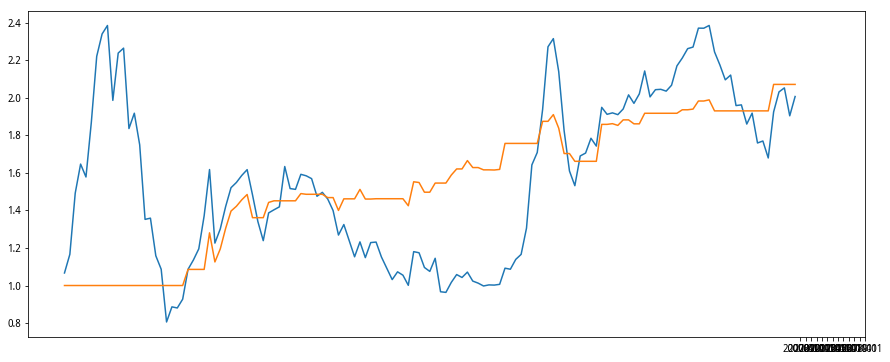

In [26]:
'''
macro.MAC_INDUSTRY_GROWTH, 数据本身延迟2个月
delay=2 how=up
1.collective_acc rolling=3
2.foreign_yoy (8,2)

delay=2 how=down
1.growth_yoy rolling=1
2.private_yoy rolling=1
3.joint_stock_yoy rolling=1
'''
def get_MAC_INDUSTRY_GROWTH(month_list):
    mei = macro.MAC_INDUSTRY_GROWTH
    q = query(mei).filter(mei.stat_month.in_(month_list))
    mac_economic = macro.run_query(q)
    mac_economic = mac_economic.set_index('stat_month').sort_index()
    return mac_economic.shift(1)

mac_industry = get_MAC_INDUSTRY_GROWTH(month_list) #无一月份数据



collective_acc = mac_industry['collective_acc']

foreign_yoy = mac_industry['foreign_yoy']

#工业增加值_同比增长
growth_yoy = mac_industry['growth_yoy']
private_yoy = mac_industry['private_yoy']
print(private_yoy)
joint_stock_yoy = mac_industry['joint_stock_yoy']





# #------------------超额收益----------------------
# #combine_rolling3_long12_short3_delay1_dowm
# collective_acc_position= get_combine_positon(collective_acc,delay=2,continus_n=2,rolling_n=3,long_n=12,short_n=3,how='dowm')

# # combine_rolling3_long12_short4_delay3_dowm
# foreign_yoy_position =get_combine_positon(foreign_yoy,delay=3,continus_n=2,rolling_n=3,long_n=12,short_n=4,how='dowm')

# # combine_rolling1_long12_short4_delay0_up
# growth_yoy_position =get_combine_positon(growth_yoy,delay=0,continus_n=2,rolling_n=1,long_n=12,short_n=4,how='up')

# # rolling3_delay2_up
# private_yoy_position=get_rolling_positon(private_yoy,n=3,delay=2,how='up')

# # rolling1_delay0_up
# joint_stock_yoy_position= get_rolling_positon(joint_stock_yoy,n=1,delay=0,how='up')



#------------------超额收益/最大回撤----------------------


# lsma_long12_short3_delay0_up-----7.857489
collective_acc_position=  get_position_from_long_short_monving_average(collective_acc,long_n=12,short_n=3,delay=0,how='up')

# continus_increase_delay2_up 14-----14.19465
foreign_yoy_position =get_position_from_continus_increase(foreign_yoy,n=2,delay=2,how='up')

# combine_rolling1_long12_short4_delay0_up 7.2
growth_yoy_position =get_combine_positon(growth_yoy,delay=0,continus_n=2,rolling_n=1,long_n=12,short_n=4,how='up')

# combine_rolling3_long12_short3_delay2_up  9.2
private_yoy_position=get_combine_positon(private_yoy,delay=2,continus_n=2,rolling_n=3,long_n=12,short_n=3,how='up')


# rolling1_delay0_up 6.6
joint_stock_yoy_position= get_rolling_positon(joint_stock_yoy,n=1,delay=0,how='up')



all_position = pd.concat([collective_acc_position,foreign_yoy_position,growth_yoy_position,private_yoy_position,joint_stock_yoy_position],axis=1)
col = ["collective_acc_position","foreign_yoy_position","growth_yoy_position","private_yoy_position","joint_stock_yoy_position"]
all_position.columns = col

all_position = all_position.fillna(0)
index = all_position.index

weights = [1,1,1,1,1]
combine_position = (all_position[col] * weights).sum(axis=1)
df_position = pd.DataFrame(combine_position,index=index,columns=['position'])
df_position = df_position / sum(weights)

def fun_(x):
    if x > 0.45:
        y = 1
    elif x < 0.4:
        y = 0
    else:
        y = 0.5
    return y
df_position = df_position.applymap(fun_)






get_profit_res(df_position,start_date,end_date)
# dict_=get_all_position(joint_stock_yoy,delay_list=[0,3],continus_n=2,rolling_n=[1,3],long_n=[12,14],short_n=[3,4],how=["up","dowm"])
# res_=get_all_res(dict_)
# plt.figure(figsize=(16,50), dpi= 70)
# sns.heatmap(res_,annot=True, vmax=3,vmin = 0 ,cmap="YlGnBu")

,net_value,net_value_timing,win_rate,profit_ratio,max_drawdown,res_score
2019-01,0.684907,3.139847,0.633333,4.584344,0.283937,16.145641


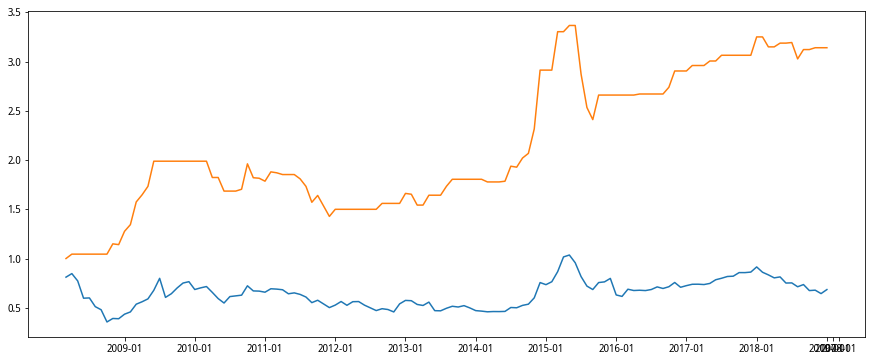

In [17]:
#消费者景气指数
def get_mac_economic_idx(month_list):
    mei = macro.MAC_CONSUMER_BOOM_IDX
    q = query(mei).filter(mei.stat_month.in_(month_list))
    mac_economic = macro.run_query(q)
    mac_economic = mac_economic.set_index('stat_month').sort_index()
    return mac_economic.shift(1)

t = get_mac_economic_idx(month_list)


satisfaction_idx = t['satisfaction_idx']

confidence_idx = t['confidence_idx']



#------------------超额收益----------------------
# # combine_rolling1_long13_short3_delay1_dowm
# satisfaction_idx_position= get_combine_positon(satisfaction_idx,delay=1,continus_n=2,rolling_n=1,long_n=13,short_n=3,how='dowm')
# # combine_rolling1_long12_short3_delay1_dowm
# confidence_idx_position=get_combine_positon(confidence_idx,delay=1,continus_n=2,rolling_n=1,long_n=12,short_n=3,how='dowm')

# ------------------超额收益/最大回撤----------------------
# combine_rolling1_long13_short3_delay1_dowm   17
satisfaction_idx_position= get_combine_positon(satisfaction_idx,delay=1,continus_n=2,rolling_n=1,long_n=13,short_n=3,how='dowm')
# combine_rolling3_long13_short3_delay1_dowm  13.0
confidence_idx_position=get_combine_positon(confidence_idx,delay=1,continus_n=2,rolling_n=3,long_n=13,short_n=3,how='dowm')





all_position = pd.concat([satisfaction_idx_position, confidence_idx_position],axis=1)
col = ["satisfaction_idx_position", "confidence_idx_position"]
all_position.columns = col

all_position = all_position.fillna(0)
index = all_position.index

weights = [1,1]
combine_position = (all_position[col] * weights).sum(axis=1)
df_position = pd.DataFrame(combine_position,index=index,columns=['position'])
df_position = df_position / sum(weights)

def fun_(x):
    if x > 0.45:
        y = 1
    elif x < 0.4:
        y = 0
    else:
        y = 0.5
    return y
df_position = df_position.applymap(fun_)




get_profit_res(df_position,start_date,end_date)
# dict_=get_all_position(confidence_idx,delay_list=[0,3],continus_n=2,rolling_n=[1,3],long_n=[12,14],short_n=[3,4],how=["up","dowm"])
# res_=get_all_res(dict_)
# plt.figure(figsize=(16,50), dpi= 70)
# sns.heatmap(res_,annot=True, vmax=3,vmin = 0 ,cmap="YlGnBu")


,net_value,net_value_timing,win_rate,profit_ratio,max_drawdown,res_score
2019-06,1.603792,4.893713,0.776471,3.051338,0.1047,29.143718


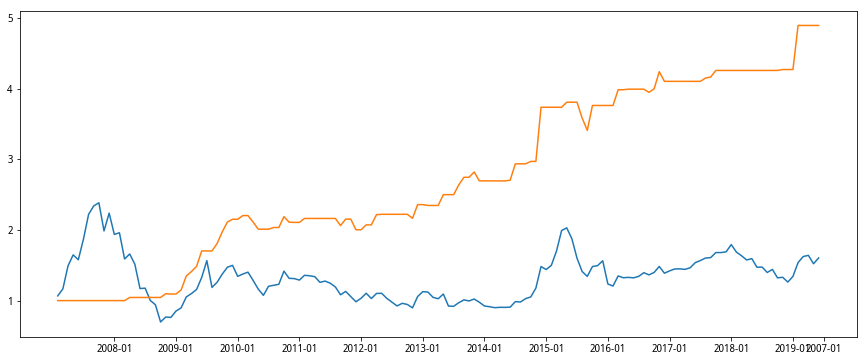

In [25]:
#-------------------最大收益

#删除一些脱后腿的因子
# all_position = pd.concat([
#                         #3.03584
#                         m1_m2yoy_position
#                         #3.162438
#                         ,ppi_cpi_position
    
#                          #2.858254
#                         ,pmi_position
#                             #3.33351	
#                           ,produce_idx_position
#                            #3.254186
#                           ,import_idx_position
#                             #3.140461
#                           ,delivery_time_idx_position
#                           #3.003598
#                           ,finished_produce_idx_position
    
    
#                           #3.18047	
#                           ,purchase_quantity_idx_position
    
    
    
    
#                           #3.624592
#                           ,expand_yoy_position
#                             #2.756764
#                           ,secondary_yoy_position
#                             #2.56177	
#                           ,primary_yoy_position
            
#                             #2.83244
#                         ,collective_acc_position
    
    
#                             #-4.293502	
#                           ,foreign_yoy_position
    
    
#                               #-3.475946	
#                         ,growth_yoy_position
#                              #-3.373125	
#                         ,private_yoy_position
#                            #-3.276948	
#                         ,joint_stock_yoy_position
    
    
    
    
#                          #-3.937443	
#                           ,satisfaction_idx_position
    
#                         #-3.706915	
#                           ,confidence_idx_position
              

                   

#                          ],axis=1)


#---------超额收益/回撤最大
#删除一些脱后腿的因子
all_position = pd.concat([
#                      20.946291
                        m1_m2yoy_position
#                      14.458519
                        ,ppi_cpi_position
#                      19.499391
                        ,pmi_position
#                       16.018145
                          ,produce_idx_position
                     #23.120024
#                           ,import_idx_position
#                      19.989924
                          ,delivery_time_idx_position
#                       22.478943
#                           ,finished_produce_idx_position
    
#                       20.09286
                     
                          ,purchase_quantity_idx_position
    
    
    
    
#                     17.061236
                          ,expand_yoy_position
#                          12.548646
                          ,secondary_yoy_position
#                      13.737585
                          ,primary_yoy_position
#                       22.782997
                        ,collective_acc_position
    
    
#                           15.531379
                          ,foreign_yoy_position
    
#                     14.98865
#                         ,growth_yoy_position
#                      18.217778
                        ,private_yoy_position
#                      13.21027
                        ,joint_stock_yoy_position
    
    
    
    
#                       15.948357
                          ,satisfaction_idx_position
    
#                       15.319743
                          ,confidence_idx_position
              

                   

                         ],axis=1)
col = [
      "m1_m2yoy_position"
      ,"ppi_cpi_position"
    
        ,"pmi_position"
      ,"produce_idx_position"
      ,"import_idx_position"
      ,"delivery_time_idx_position"
      ,"finished_produce_idx_position"
      ,"purchase_quantity_idx_position"

        
      ,"expand_yoy_position"
      ,"secondary_yoy_position"
      ,"primary_yoy_position"

        
      ,"collective_acc_position"
        ,"foreign_yoy_position"
        ,"growth_yoy_position"
        ,"private_yoy_position"
        ,"joint_stock_yoy_position"
    
      ,"satisfaction_idx_position"
      ,"confidence_idx_position"

        

      ]

# all_position.columns = col
all_position = all_position.fillna(0)
index = all_position.index

weights = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

combine_position = (all_position * weights).sum(axis=1)
df_position = pd.DataFrame(combine_position,index=index,columns=['position'])
df_position = df_position / sum(weights)

def fun_(x):
    if x > 0.45:
        y = 1
    elif x < 0.4:
        y = 0
    else:
        y = 0.5
    return y
df_position_ = df_position.applymap(fun_)

get_profit_res(df_position_,start_date,end_date)

In [19]:
df_position_ 


,position
2007-02,0.0
2007-03,0.0
2007-04,0.0
2007-05,0.0
2007-06,0.0
2007-07,0.0
2007-08,0.0
2007-09,0.0
2007-10,0.0
2007-11,0.0


In [20]:


profit = get_profit_monthly_(start_date=start_date,end_date=end_date)
profit[profit<0]=0

all_position=pd.concat([df_position,profit],axis=1).dropna()

for index in all_position.index:
    if list(all_position.index).index(index)<=5:
        all_position.loc[index,"thre"]= 0.45
    else:
        FPR, recall, thresholds = roc_curve(all_position.loc[:index,"pct"],all_position.loc[:index,"position"],pos_label=1)
        maxindex = (recall - FPR).tolist().index(max(recall - FPR))
        threshold=thresholds[maxindex]
        all_position.loc[index,"thre"]=threshold
        
        


,net_value,net_value_timing,win_rate,profit_ratio,max_drawdown,res_score
2019-06,1.603792,2.554197,0.807692,1.592598,0.242153,6.576822


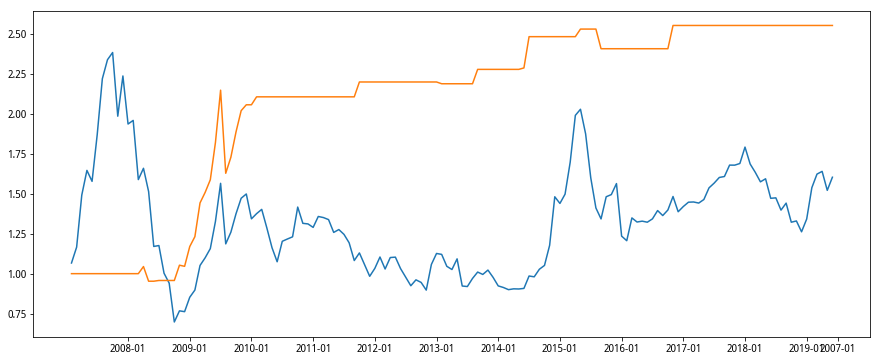

In [21]:
all_position["position"]=(all_position["position"]>all_position["thre"])*1
get_profit_res(all_position["position"],start_date,end_date)

